In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import metric_classifier

In [2]:
data = pd.read_csv('dataset_user_knowledge.csv')
data.head()

,V1,V2,V3,V4,V5,Class
0,0.00,0.00,0.00,0.00,0.00,4
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,2
3,0.10,0.10,0.15,0.65,0.30,3
4,0.08,0.08,0.08,0.98,0.24,2


In [3]:
X = data[data.columns[:-1]]
X.head()

,V1,V2,V3,V4,V5
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


In [4]:
classes, counts = np.unique(data.Class, return_counts=True)
dict(zip(classes, counts))

{1: 102, 2: 129, 3: 122, 4: 24, 5: 26}

In [5]:
y = data.Class.apply(lambda status: np.where(classes == status)[0][0])
y.head()

0    3
1    0
2    1
3    2
4    1
Name: Class, dtype: int64

In [6]:
means = X.mean()
stds = X.std()

In [7]:
means

V1    0.353141
V2    0.355940
V3    0.457655
V4    0.431342
V5    0.456360
dtype: float64

In [8]:
stds

V1    0.212018
V2    0.215531
V3    0.246684
V4    0.257545
V5    0.266775
dtype: float64

In [9]:
def norm_column(column):
    return (X.loc[:, column] - means[column]) / stds[column]


X_norm = pd.DataFrame(dict([(column, norm_column(column)) for column in X.columns]))
X_norm.head()

,V1,V2,V3,V4,V5
0,-1.665623,-1.651461,-1.855232,-1.674824,-1.710652
1,-1.288296,-1.280284,-1.449854,-0.742948,1.662973
2,-1.382628,-1.373078,-1.652543,-0.704120,-0.473656
3,-1.193964,-1.187490,-1.247165,0.849007,-0.586110
4,-1.288296,-1.280284,-1.530930,2.130337,-0.811018


In [10]:
X_norm.mean()

V1   -2.936719e-16
V2   -1.645775e-15
V3    7.834924e-16
V4   -6.545633e-16
V5   -4.049697e-17
dtype: float64

In [11]:
X_norm.std()

V1    1.0
V2    1.0
V3    1.0
V4    1.0
V5    1.0
dtype: float64

In [12]:
X = X_norm

In [13]:
def get_class(kernel_type, distance_type, window_type, window_param, X, y, argument):
    weights = metric_classifier.calc_class_weight(kernel_type, distance_type, window_type,
                                                  window_param, X, y, argument)
    return weights.index(max(weights))

In [23]:
def get_confusion_matrix(kernel_type, distance_type, window_type, window_param):
    classes_cnt = len(y.unique())
    ans = [[0 for j in range(classes_cnt)] for i in range(classes_cnt)]
    for cur_idx in range(data.shape[0]):
        true_class = y[cur_idx]
        argument = X.loc[cur_idx]
        X_train = X.drop([cur_idx])
        y_train = y.drop([cur_idx])
        predicted_class = get_class(kernel_type, distance_type, window_type, window_param,
                                    X_train.values, y_train, argument)
        ans[true_class][predicted_class] += 1
    return ans

In [24]:
def get_f_score(cm):
    k = len(cm)
    
    def get_class_cnt(idx):
        return sum(cm[idx])


    def get_precision_and_recall(idx):
        tp = cm[idx][idx]
        tp_fp = sum([cm[j][idx] for j in range(k)])
        tp_fn = get_class_cnt(idx)
        precision = 0 if tp_fp == 0 else tp / tp_fp
        recall = 0 if tp_fn == 0 else tp / tp_fn
        return precision, recall


    def calc_f_score(precision, recall):
        if precision + recall == 0:
            return 0
        else:
            return 2 * precision * recall / (precision + recall)


    def get_f_score(idx):
        precision, recall = get_precision_and_recall(idx)
        return calc_f_score(precision, recall)
    
    
    total_cnt = sum([sum(cm[i]) for i in range(k)])
    macro_f_score = sum([get_f_score(i) * get_class_cnt(i) for i in range(k)]) / total_cnt
    micro_precision = sum([get_precision_and_recall(i)[0] * get_class_cnt(i) for i in range(k)]) / total_cnt
    micro_recall = sum([get_precision_and_recall(i)[1] * get_class_cnt(i) for i in range(k)]) / total_cnt
    micro_f_score = calc_f_score(micro_precision, micro_recall)
    return micro_f_score

In [20]:
distances = []
for first_index in range(X.shape[0]):
    for second_index in range(X.shape[0]):
        first = X.loc[first_index].values
        second = X.loc[second_index].values
        distances.append(metric_classifier.calc_dist(metric_classifier.DistanceType.EUCLIDEAN, first, second))
distances.sort()
total_dists = len(distances)
distances[int(0.90 * total_dists)]

4.232354557741518

In [25]:
def params_gen():
    for kernel_type in metric_classifier.KernelType:
        for distance_type in metric_classifier.DistanceType:
            for window_type in metric_classifier.WindowType:
                if window_type == metric_classifier.WindowType.FIXED:
                    window_params = np.linspace(0.1, 4, 10)
                else:
                    window_params = range(1, 101, 10)
                for window_param in window_params:
                    yield (kernel_type, distance_type, window_type, window_param)

In [26]:
max_f_score = -1
best_kernel_type = None
best_distance_type = None
best_window_type = None
best_window_param = None
for kernel_type, distance_type, window_type, window_param in tqdm(list(params_gen())):
    confusin_matrix = get_confusion_matrix(kernel_type, distance_type, window_type, window_param)
    cur_f_score = get_f_score(confusin_matrix)
    if cur_f_score > max_f_score:
        max_f_score = cur_f_score
        best_kernel_type = kernel_type
        best_distance_type = distance_type
        best_window_type = window_type
        best_window_param = window_param

100%|██████████| 600/600 [26:18<00:00,  2.63s/it]


In [27]:
max_f_score, best_kernel_type, best_distance_type, best_window_type, best_window_param

(0.8557146559202522,
 <KernelType.TRIWEIGHT: 'triweight'>,
 <DistanceType.MANHATTAN: 'manhattan'>,
 <WindowType.VARIABLE: 'variable'>,
 41)

In [61]:
f_scores_fixed = []
h_fixed = np.linspace(0.1, 5, 80)
for h in tqdm(h_fixed):
    confusin_matrix = get_confusion_matrix(best_kernel_type, best_distance_type, metric_classifier.WindowType.FIXED, h)
    cur_f_score = get_f_score(confusin_matrix)
    f_scores_fixed.append(cur_f_score)

100%|██████████| 80/80 [03:21<00:00,  2.52s/it]


In [63]:
f_scores_variable = []
k_variable = range(1, 201, 2)
for k in tqdm(k_variable):
    confusin_matrix = get_confusion_matrix(best_kernel_type, best_distance_type, metric_classifier.WindowType.VARIABLE, k)
    cur_f_score = get_f_score(confusin_matrix)
    f_scores_variable.append(cur_f_score)

100%|██████████| 100/100 [04:05<00:00,  2.45s/it]


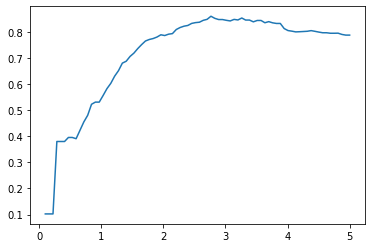

In [62]:
plt.plot(h_fixed, f_scores_fixed)

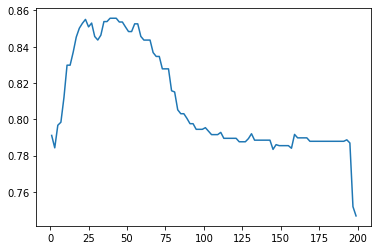

In [64]:
plt.plot(k_variable, f_scores_variable)